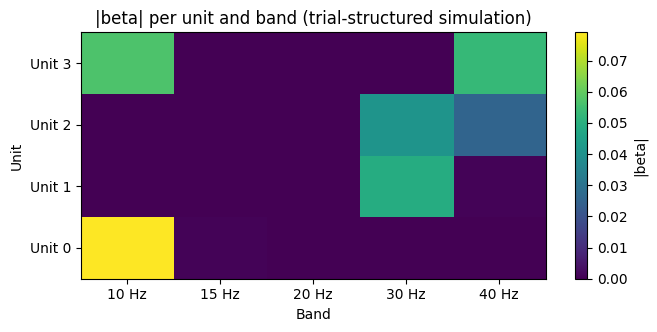

Saved trial-structured dataset to: ./data/sim_with_trials.pkl


/home/bowen27/miniconda3/envs/jax312/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [1]:
# Re-run with a fix for advanced indexing order (use np.take along axis to preserve (J, T_fine)).
# Also: ensure that the band-activity mask is strictly enforced in beta_true and downstream use.

import numpy as np
import math
import pickle
import matplotlib.pyplot as plt
seed = np.random.randint(0, 1000000)
rng = np.random.default_rng(seed)

# ---------------------- 1) Global parameters ----------------------
freqs_hz = np.asarray([10.0, 15.0, 20.0, 30.0, 40.0])  # J bands
J = freqs_hz.size

R = 50              # trials
S = 4               # units
k_active = 2        # active bands per unit

fs = 1000.0
dt = 1.0 / fs
duration_sec = 10.0
T = int(round(duration_sec * fs))
time = np.arange(T) * dt

delta_spk = 0.001
T_fine = int(round(duration_sec / delta_spk))
t_fine = np.arange(T_fine) * delta_spk

half_bw_hz = np.asarray([0.01] * J)
lam = math.pi * half_bw_hz
lam_individual = lam * 10
sigma_v_shared = np.asarray([6.0, 6.5, 7.0, 6.5, 6.0])
sigma_v_delta  = sigma_v_shared
sigma_eps      = np.asarray([20.0] * J)

# ---------------------- 2) Shared OU ----------------------
Z_shared = np.zeros((J, T), dtype=np.complex128)
sqrt_dt_over_2 = math.sqrt(dt / 2.0)
for j in range(J):
    for n in range(1, T):
        Z_shared[j, n] = ((1.0 - lam[j] * dt) * Z_shared[j, n - 1] +
                          sigma_v_shared[j] * sqrt_dt_over_2 *
                          (rng.standard_normal() + 1j * rng.standard_normal()))

# ---------------------- 3) Trial-specific deltas + observation noise ----------------------
Delta = np.zeros((R, J, T), dtype=np.complex128)
Eps   = np.zeros((R, J, T), dtype=np.complex128)
for r in range(R):
    for j in range(J):
        for n in range(1, T):
            Delta[r, j, n] = ((1.0 - lam_individual[j] * dt) * Delta[r, j, n - 1] +
                               sigma_v_delta[j] * sqrt_dt_over_2 *
                               (rng.standard_normal() + 1j * rng.standard_normal()))
        Eps[r, j, :] = (rng.standard_normal(T) + 1j * rng.standard_normal(T)) * sigma_eps[j]

Z_lat = Z_shared[None, :, :] + Delta
Z_obs = Z_lat + Eps

# ---------------------- 4) Predictors at spike grid ----------------------
def nearest_idx(centres, t):
    c = np.asarray(centres, float).ravel()
    tt = np.asarray(t, float).ravel()
    ir = np.searchsorted(c, tt, side="left")
    il = np.clip(ir - 1, 0, c.size - 1)
    ir = np.clip(ir, 0, c.size - 1)
    use_r = np.abs(c[ir] - tt) < np.abs(c[il] - tt)
    return np.where(use_r, ir, il).astype(np.int32)

k_idx = nearest_idx(time, t_fine)  # (T_fine,)
phase = 2.0 * np.pi * freqs_hz[:, None] * t_fine[None, :]
rot = np.exp(-1j * phase, dtype=np.complex128)  # (J, T_fine)

Ztil_R = np.zeros((R, J, T_fine), dtype=float)
Ztil_I = np.zeros((R, J, T_fine), dtype=float)
for r in range(R):
    # Use np.take to keep axis order (J, T_fine)
    Zr_fine = np.take(Z_lat[r], k_idx, axis=1) * rot  # (J, T_fine)
    Ztil_R[r] = Zr_fine.real
    Ztil_I[r] = Zr_fine.imag

# ---------------------- 5) Ground-truth beta (with strict masking enforcement) ----------------------
def random_beta_with_mask(rng, J, k_active=3):
    mask = np.zeros(J, dtype=bool)
    active = rng.choice(J, size=k_active, replace=False)
    mask[active] = True
    b0 = rng.normal(loc=-2.0, scale=0.4)
    coeffs = [b0]
    for j in range(J):
        if mask[j]:
            mag = rng.uniform(0.3, 0.8) * 0.1
            theta = rng.uniform(-np.pi, np.pi)
            coeffs += [mag * np.cos(theta), mag * np.sin(theta)]
        else:
            coeffs += [0.0, 0.0]
    return np.array(coeffs, float), mask

beta_true_list = []
masks = []
for s in range(S):
    b, m = random_beta_with_mask(rng, J, k_active=k_active)
    # Just to be extra sure: enforce the mask explicitly (paranoid if generator ever changes)
    bR = np.array(b[1:1+J])
    bI = np.array(b[1+J:1+2*J])
    bR[~m] = 0.0
    bI[~m] = 0.0
    beta_true_s = np.concatenate([[b[0]], bR, bI])
    beta_true_list.append(beta_true_s)
    masks.append(m)
beta_true = np.stack(beta_true_list)  # (S, 1+2J)
masks = np.stack(masks)               # (S, J)

# ---------------------- 6) Spike history ----------------------
n_lags = 20
lag_times = (np.arange(1, n_lags + 1) * delta_spk)
gamma_true = -1.5 * np.exp(-lag_times / 0.03)

def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-x))

# ---------------------- 7) Generate spikes ----------------------
spikes = np.zeros((R, S, T_fine), dtype=np.uint8)
linpred = np.zeros((R, S, T_fine), dtype=float)

for r in range(R):
    for s in range(S):
        b0 = beta_true[s, 0]
        bR = beta_true[s, 1:1+J]
        bI = beta_true[s, 1+J:1+2*J]
        # Explicitly mask bR and bI, just in case
        msk = masks[s]
        bR_masked = bR * msk
        bI_masked = bI * msk
        psi_bands = (bR_masked[:, None] * Ztil_R[r] + bI_masked[:, None] * Ztil_I[r]).sum(axis=0)  # (T_fine,)
        h = np.zeros(n_lags, dtype=float)
        for t in range(T_fine):
            hist_term = np.dot(h, gamma_true)
            psi = b0 + psi_bands[t] + hist_term
            p = sigmoid(psi)
            y = rng.binomial(1, p)
            spikes[r, s, t] = y
            linpred[r, s, t] = psi
            if n_lags > 0:
                h[1:] = h[:-1]
                h[0] = y

# ---------------------- 8) LFP per trial ----------------------
carrier_latent = np.exp(2j * np.pi * freqs_hz[:, None] * time[None, :])  # (J, T)
LFP = np.zeros((R, T), dtype=float)
for r in range(R):
    LFP[r] = np.sum((carrier_latent * Z_obs[r]).real, axis=0)

# ---------------------- 9) Save ----------------------
data = dict(
    freqs_hz=freqs_hz, fs=fs, duration_sec=duration_sec,
    R=R, S=S, J=J, delta_spk=delta_spk, T=T, T_fine=T_fine,
    time=time, t_fine=t_fine,
    lam=lam, sigma_v_shared=sigma_v_shared, sigma_v_delta=sigma_v_delta, sigma_eps=sigma_eps,
    Z_shared=Z_shared, Delta=Delta, Z_lat=Z_lat, Eps=Eps, Z_obs=Z_obs,
    Ztil_R=Ztil_R, Ztil_I=Ztil_I, LFP=LFP,
    beta_true=beta_true, masks=masks, n_lags=n_lags, gamma_true=gamma_true,
    spikes=spikes, linpred=linpred,
)

out_path = "./data/sim_with_trials.pkl"
import os
if not os.path.exists(out_path):
    os.makedirs(os.path.dirname(out_path), exist_ok=True)
with open(out_path, "wb") as f:
        pickle.dump(data, f)

# ---------------------- 10) Plot |beta| heatmap ----------------------
betaR = beta_true[:, 1:1+J]
betaI = beta_true[:, 1+J:1+2*J]
# Explicitly mask for plotting too
betaR_masked = betaR * masks
betaI_masked = betaI * masks
beta_mag = np.sqrt(betaR_masked**2 + betaI_masked**2)  # (S, J)

plt.figure(figsize=(7.5, 3.2))
plt.imshow(beta_mag, aspect="auto", origin="lower")
plt.colorbar(label="|beta|")
plt.yticks(np.arange(S), [f"Unit {s}" for s in range(S)])
plt.xticks(np.arange(J), [f"{int(f)} Hz" for f in freqs_hz])
plt.xlabel("Band")
plt.ylabel("Unit")
plt.title("|beta| per unit and band (trial-structured simulation)")
plt.show()

print("Saved trial-structured dataset to:", out_path)

# Inference

import sys
parent_dir = "/orcd/data/ekmiller/001/bowen/spike-field-joint-inference"
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)

from src.trial_tfr import compute_trial_tfr_multitaper
window_sec = 0.2 # seconds 
NW = 1
cutoff_freq = 60
fs = fs
# swap axes of the channel data 
Y_trials, centres_sec, freqs_sel, M = compute_trial_tfr_multitaper(
    LFP, fs=fs, window_sec=window_sec, NW=NW, f_max_hz=cutoff_freq
)  # -> (R, Ktaper=1, J, Kframes)



import sys, importlib, numpy as np
from dataclasses import dataclass
from typing import Dict, Tuple
from tqdm.auto import tqdm


In [2]:
# --- Paths & imports you already had ---
parent_dir = "/orcd/data/ekmiller/001/bowen/spike-field-joint-inference"
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)
# reload the em_ct_hier_jax module
import importlib
import src.em_ct_hier_jax
importlib.reload(src.em_ct_hier_jax)
from src.em_ct_hier_jax import em_ct_hier_jax
from src.utils_spikes import build_history_lags_binary_multi

# ------------------ your inputs (as in your snippet) ------------------
spike_train = np.asarray(spikes, dtype=np.uint8)     # (R, S, T) 0/1
Y_trials    = np.asarray(Y_trials)                        # (R, M, J, K) complex
freqs_hz    = np.asarray(freqs_sel, dtype=float)          # (J,)
centres_sec = np.asarray(centres_sec, dtype=float)        # (K,)
delta_spk = 0.001
delta_spk   = float(delta_spk)                            # e.g., 0.001
db          = float(window_sec)                           # LFP block length/step (sec)

R, S, T = spikes.shape
R2, M, J, K = Y_trials.shape
assert R2 == R, "n_trial must match between spikes and Y_trials"
assert freqs_hz.shape == (J,), "freqs_hz must be (J,)"
assert centres_sec.shape == (K,), "centres_sec must be (K,)"


em_res = em_ct_hier_jax(
    Y_trials=Y_trials,
    db=db,
    max_iter=5000,
    tol=1e-4,
    obs_noise_shared=True,   # or False for per-band noise
    sig_eps_init=5.0,       # SD, not variance
    # Use moment-based warm start for shared X:
    lam_X_init=None,         # ← warm start φ/λ from pooled Y
    sigv_X_init=None,        # ← warm start σ_v from moments
    # Let D start faster than X (defaults do this if None):
    lam_D_init=None,
    sigv_D_init=None,
    noise_floor=1e-8,
    verbose=True,
    # Equal-weight pooling for the first few EM steps:
    no_pool_iters=3,          # try 3–5 if δ is still slow to emerge
    log_every=5000
)
# Expect em_res.X_mean: (J,M,K), em_res.D_mean: (R,J,M,K)
X_mean = np.asarray(em_res.X_mean)            # (J,M,K) complex
D_mean = np.asarray(em_res.D_mean)  

[EM-CT-HIER-JAX] iter 0  Q=-1.469118e+05


(50, 1, 12, 50)
(12, 1, 50)


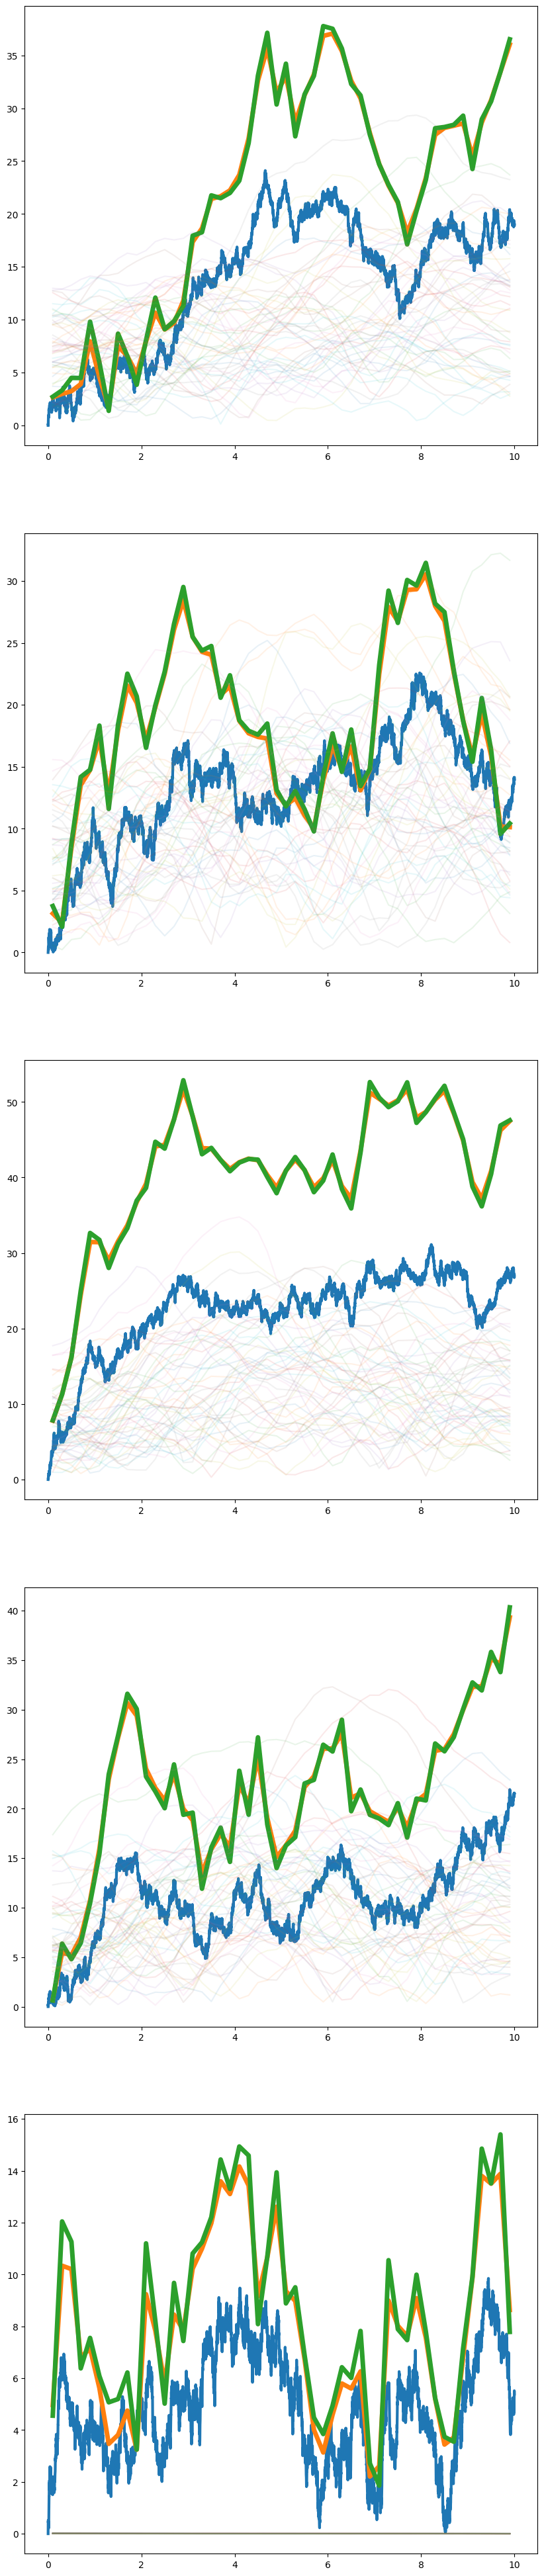

In [3]:
print(Y_trials.shape)
print(X_mean.shape)
# average 
ave_Y_trials = np.mean(Y_trials, axis=0)
true_freq_len = Z_shared.shape[0] 
true_freqs = np.asarray([10.0, 15.0, 20.0, 30.0, 40.0])  # J bands
true_freqs_idx = np.argmin(np.abs(freqs_hz[:, None] - true_freqs), axis=0)
# find the index of the freqs_hz that are closest to the true freqs
figs, axs = plt.subplots(true_freq_len, 1, figsize=(10, true_freq_len*10)) 

for i in range(true_freq_len):
    axs[i].plot(time, np.abs(Z_shared[i]), linewidth=3)
    axs[i].plot(centres_sec, np.abs(X_mean[true_freqs_idx[i], 0, :].flatten()), linewidth=5)
    axs[i].plot(centres_sec, np.abs(ave_Y_trials[0, true_freqs_idx[i], :].flatten()), linewidth=5)
    for j in range(R):
        axs[i].plot(centres_sec, np.abs(D_mean[j, true_freqs_idx[i], 0, :].flatten()), alpha=0.1)

        # axs[i].plot(time, np.abs(Delta[j, i, :].flatten()), alpha=0.1)

plt.show()  

In [4]:
print(D_mean.shape)

(50, 12, 1, 50)


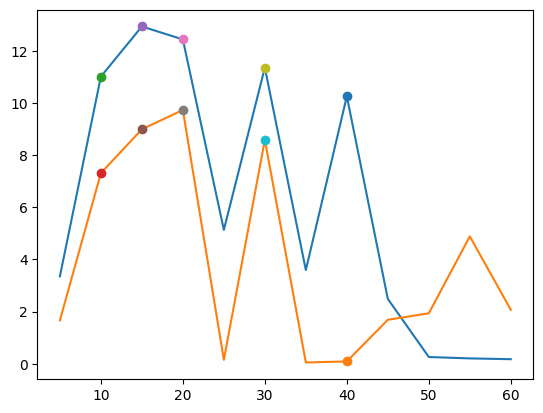

In [5]:
plt.plot(freqs_hz, em_res.sigv_X)
plt.plot(freqs_hz, em_res.sigv_D)
for i in range(len(true_freqs)):
    plt.plot(true_freqs[i], em_res.sigv_X[true_freqs_idx[i]], "o")
    plt.plot(true_freqs[i], em_res.sigv_D[true_freqs_idx[i]], "o")

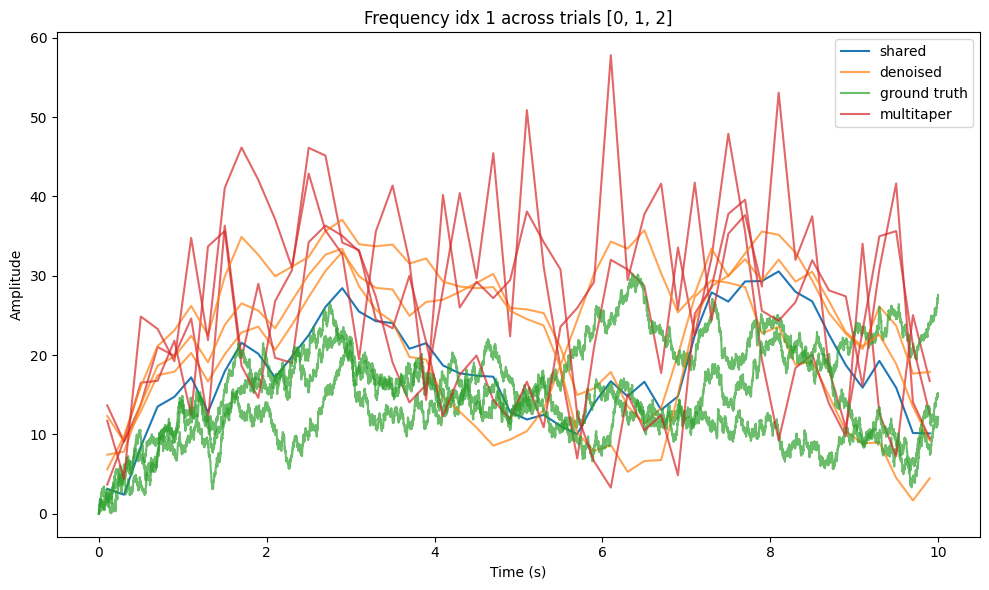

In [6]:
# trial specific denoising 
trial_id = [0,1,2]
freq_idx = 1

colors = {
    "shared": "C0",
    "denoised": "C1",
    "ground_truth": "C2",
    "multitaper": "C3"
}

plt.figure(figsize=(10,6))
# Plot shared component only once for all trials
plt.plot(
    centres_sec,
    np.abs(X_mean[true_freqs_idx[freq_idx], 0, :].flatten()),
    color=colors["shared"],
    alpha=1,
    label="shared"
)

for i in trial_id:
    # denoised (shared + trial)
    plt.plot(
        centres_sec,
        np.abs(X_mean[true_freqs_idx[freq_idx], 0, :].flatten() + D_mean[i, true_freqs_idx[freq_idx], 0, :].flatten()),
        color=colors["denoised"],
        alpha=0.7,
        label="denoised" if i==trial_id[0] else None
    )
    # ground truth
    plt.plot(
        time,
        np.abs(Z_lat[i, freq_idx, :].flatten()),
        color=colors["ground_truth"],
        alpha=0.7,
        label="ground truth" if i==trial_id[0] else None
    )
    # multitaper
    plt.plot(
        centres_sec,
        np.abs(Y_trials[i, 0, true_freqs_idx[freq_idx], :].flatten()),
        color=colors["multitaper"],
        alpha=0.7,
        label="multitaper" if i==trial_id[0] else None
    )

plt.legend()
plt.title(f"Frequency idx {freq_idx} across trials {trial_id}")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.tight_layout()
plt.show()

In [7]:
import numpy as np
import pandas as pd

# ----- helpers -----
def nearest_idx(t_full, t_q):
    t_full = np.asarray(t_full, float).ravel()
    t_q = np.asarray(t_q, float).ravel()
    ir = np.searchsorted(t_full, t_q, side="left")
    il = np.clip(ir - 1, 0, len(t_full) - 1)
    ir = np.clip(ir, 0, len(t_full) - 1)
    use_r = np.abs(t_full[ir] - t_q) < np.abs(t_full[il] - t_q)
    return np.where(use_r, ir, il).astype(np.int32)

def safe_pearson(a, b):
    a = np.asarray(a, float).ravel()
    b = np.asarray(b, float).ravel()
    a_c = a - a.mean()
    b_c = b - b.mean()
    denom = np.sqrt((a_c**2).sum() * (b_c**2).sum())
    if denom == 0.0:
        return np.nan
    return float((a_c @ b_c) / denom)

# If you don't already have a mapping from "true" band index -> multitaper band index:
def map_true_to_mt(freqs_true, freqs_mt):
    freqs_true = np.asarray(freqs_true, float)
    freqs_mt   = np.asarray(freqs_mt, float)
    return np.array([np.argmin(np.abs(freqs_mt - f)) for f in freqs_true], dtype=int)

# ----- configuration (use your existing freq_idx or loop over many) -----
# freq_idx is the index in your *simulated* bands (Z_lat[:, freq_idx, :])
try:
    j_est = int(true_freqs_idx[freq_idx])  # mapped to multitaper index
except NameError:
    true_freqs_idx = map_true_to_mt(freqs_hz, freqs_hz)  # trivial mapping if same grid
    j_est = int(true_freqs_idx[freq_idx])

j_true = int(freq_idx)   # ground-truth index in Z_lat

# ----- align GT to K-frame grid -----
k_idx = nearest_idx(time, centres_sec)  # map length-K frames to raw time

# Ground-truth amplitude per trial on K:
gt_amp_rk = np.abs(Z_lat[:, j_true, :][:, k_idx])          # (R, K)

# Observed multitaper amplitude per trial on K:
mt_amp_rk = np.abs(Y_trials[:, 0, j_est, :])               # (R, K)  (assumes M=1; if M>1 choose taper)

# Shared amplitude (same for all trials), broadcast to (R, K):
X_amp_k   = np.abs(X_mean[j_est, 0, :])                     # (K,)
X_amp_rk  = np.broadcast_to(X_amp_k[None, :], gt_amp_rk.shape)

# Denoised amplitude per trial:
den_amp_rk = np.abs(X_mean[j_est, 0, :][None, :] + D_mean[:, j_est, 0, :])  # (R, K)

# ----- per-trial correlations -----
corr_mt  = np.array([safe_pearson(gt_amp_rk[r], mt_amp_rk[r])  for r in range(R)])
corr_X   = np.array([safe_pearson(gt_amp_rk[r], X_amp_rk[r])   for r in range(R)])
corr_den = np.array([safe_pearson(gt_amp_rk[r], den_amp_rk[r]) for r in range(R)])

# ----- tidy dataframe -----
df_corr = pd.DataFrame({
    "trial": np.arange(R, dtype=int),
    "r_ground_vs_multitaper": corr_mt,
    "r_ground_vs_sharedX":    corr_X,
    "r_ground_vs_denoised":   corr_den,
})
print(df_corr.head())

# quick summary stats
summary = df_corr.drop(columns=["trial"]).agg(["mean","median","std","min","max"])
print("\nSummary (across trials) for freq_idx =", j_true, "(est idx =", j_est, ")")
print(summary)



   trial  r_ground_vs_multitaper  r_ground_vs_sharedX  r_ground_vs_denoised
0      0                0.549879             0.272327              0.601952
1      1                0.590585             0.468113              0.751502
2      2                0.518097             0.839591              0.794762
3      3                0.687680             0.607006              0.722268
4      4                0.576210             0.761395              0.851354

Summary (across trials) for freq_idx = 1 (est idx = 2 )
        r_ground_vs_multitaper  r_ground_vs_sharedX  r_ground_vs_denoised
mean                  0.584416             0.566117              0.738723
median                0.585010             0.555927              0.781774
std                   0.157591             0.163550              0.166810
min                   0.076747             0.212824              0.126375
max                   0.878268             0.859242              0.958826


/tmp/ipykernel_1541938/2992404678.py:4: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


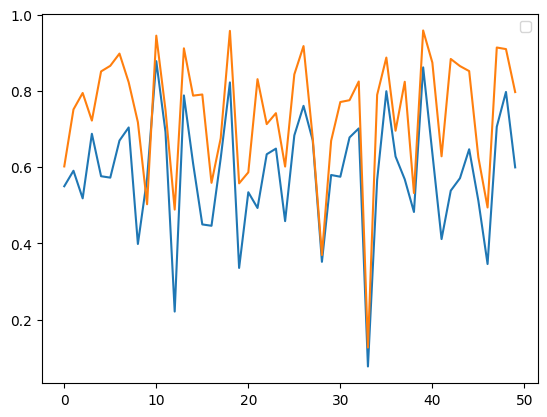

In [8]:
plt.plot(df_corr.trial, df_corr.r_ground_vs_multitaper)
# plt.plot(df_corr.trial, df_corr.r_ground_vs_sharedX)
plt.plot(df_corr.trial, df_corr.r_ground_vs_denoised)
plt.legend()
plt.show()


In [9]:
import importlib
X_mean = em_res.X_mean
D_mean = em_res.D_mean
delta_spike = 0.001

importlib.reload(importlib.import_module("src.em_ct_hier_jax"))
importlib.reload(importlib.import_module("src.utils_spikes"))
importlib.reload(importlib.import_module("src.history_hier"))
importlib.reload(importlib.import_module("src.beta_gamma_pg_fixed_latents_joint_jax"))
from src.beta_gamma_pg_fixed_latents_joint_jax  import JointSamplerConfig
from src.history_hier import (
    lag_bins_from_seconds_strict,
    build_history_lags_hier_strict,
    assert_spikes_R_S_T,
)

# 0) Ensure spikes is already (R,S,T). If not, fix upstream (align trials to a common fine grid).
spikes_rst = assert_spikes_R_S_T(spike_train)  # raises if ragged or wrong rank

# 1) Choose lags that are integer multiples of delta_spk (or this raises).
lag_bins = lag_bins_from_seconds_strict([0.001, 0.002, 0.004, 0.008, 0.016], delta_spike)

# 2) Build per-trial history (no cross-trial leakage).
H_hist = build_history_lags_hier_strict(spikes_rst, lag_bins, mode="self")

jax version: 0.7.2
jax version: 0.7.2


In [10]:
# Y_trials: complex multitaper frames, shape (R,J,M,K) or (R,M,J,K)
# res: EMHierResult from em_ct_hier_jax
# delta_spk: spike-bin width, win_sec: multitaper block length, offset_sec: first block centre time
import importlib
importlib.reload(importlib.import_module("src.upsample_ct_hier_fine"))

from src.upsample_ct_hier_fine import upsample_ct_hier_fine

ups = upsample_ct_hier_fine(
    Y_trials=Y_trials, 
    res=em_res, 
    delta_spk=delta_spk,
    win_sec=window_sec, 
    offset_sec=centres_sec[0] if centres_sec.ndim==1 else 0.0
)

# Fine-grid shared and per-trial latents
X_fine = ups.X_mean          # (J,M,Tf) complex
D_fine = ups.D_mean          # (R,J,M,Tf) complex
Z_fine = ups.Z_mean          # (R,J,M,Tf) complex


In [11]:
importlib.reload(importlib.import_module("src.beta_gamma_pg_fixed_latents_joint_jax"))
from src.beta_gamma_pg_fixed_latents_joint_jax  import JointSamplerConfig
# 2) joint β & γ sampling (all units at once)
cfg = JointSamplerConfig(
    n_warmup=100, n_samples=20, thin=5,
    use_pg_sampler=True, omega_floor=1e-6,
    tau2_intercept=1e4, tau2_beta=1e2,    # β priors
    tau2_gamma=25.0**2,                   # γ prior (if Sigma_gamma not supplied)
    standardize_reim=False, standardize_hist=False,
    use_ard_beta=True,                   # set True if you want sparsity on β
    verbose=True
)

import importlib
importlib.reload(importlib.import_module("src.beta_gamma_pg_fixed_latents_joint_jax"))
from src.beta_gamma_pg_fixed_latents_joint_jax import sample_beta_gamma_from_fixed_latents_joint
X_jax, H_jax, trace = sample_beta_gamma_from_fixed_latents_joint(
    spikes=spike_train,
    H_hist=H_hist,
    Z_fine=Z_fine,
    freqs_hz=freqs_sel,
    delta_spk=delta_spike,
    bands_idx=None,
    cfg=cfg
)


jax version: 0.7.2
jax version: 0.7.2
[JAX sampler] Using PG for ω
[JAX sampler] Preprocessing data...
[JAX sampler] Shapes: R=50, S=4, T=10000, N=500000, B=12, p_full=74, R_h=5


iter omega mean per unit: [0.1575037  0.15406865 0.15275586 0.15116731]
iter omega mean per unit: [0.15866986 0.15520341 0.15411731 0.15251853]
iter omega mean per unit: [0.15913116 0.15594792 0.15483919 0.1531124 ]
iter omega mean per unit: [0.15878924 0.15596025 0.15535238 0.15337807]
iter omega mean per unit: [0.15888407 0.15591354 0.1553518  0.15342624]
iter omega mean per unit: [0.1588681  0.15584429 0.15518153 0.15377115]
iter omega mean per unit: [0.15887419 0.15597566 0.15509181 0.15398188]
iter omega mean per unit: [0.15860625 0.15586338 0.15489301 0.15386959]
iter omega mean per unit: [0.15877066 0.15623772 0.15445508 0.15358457]
iter omega mean per unit: [0.15828751 0.15621387 0.15497086 0.15331759]
[JAX sampler] Warmup iteration 10/100
iter omega mean per unit: [0.15852437 0.15606601 0.15489234 0.15377829]
iter omega mean per unit: [0.15835624 0.15603111 0.15458813 0.15372454]
iter omega mean per unit: [0.15830945 0.15589957 0.15423848 0.15376376]
iter omega mean per unit: 

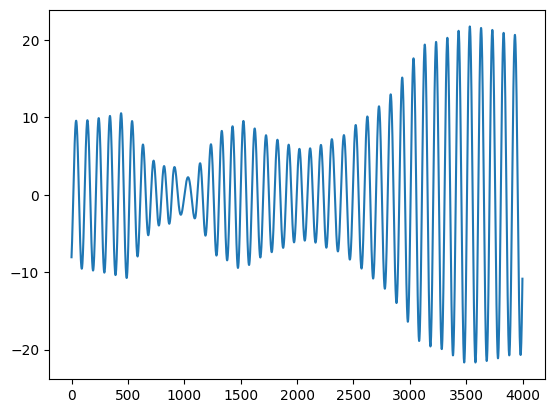

In [25]:
# one second 
start_idx = 0 
end_idx = 4000
plt.plot(X_jax[start_idx:end_idx,2])

In [19]:
trace.beta.shape

(20, 4, 74)

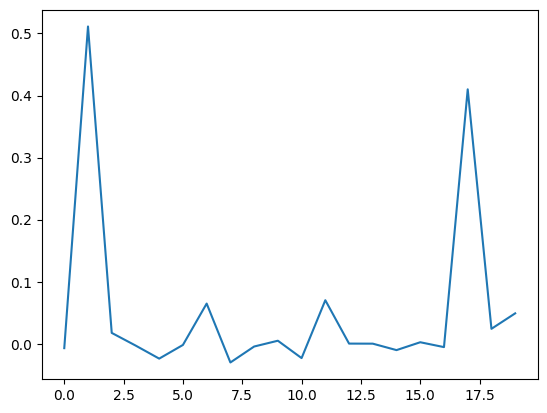

In [50]:
n_band = 12
idx = 4
plt.plot(trace.beta[:,0,idx+1]/ trace.beta[:,0, idx*n_band+1])





In [32]:
from src.beta_gamma_pg_fixed_latents_joint_jax import sample_beta_gamma_from_fixed_latents_joint
import sys
import os
sys.path.append(os.path.abspath("../src") if os.path.exists("../src") else os.path.abspath("src"))
# reload the summarize_beta_trace module
import importlib
importlib.reload(importlib.import_module("src.summarize_beta_trial"))
from src.summarize_beta_trial import summarize_beta_trace
result = summarize_beta_trace(
    trace,
    freqs_sel,
    coupled_freq_idx=None,
    fix_iter=0,
    thin_beta=1,
    burnin_frac=0.2,
    trim=True,
    alpha_fdr=0.05,
    ridge=1e-4,
    verbose=True
)

Burn in samples 4
12
(16, 4, 74)
[Train 0] BH-FDR @ α=0.05: 3 significant bands
  b=  9 | f= 50.000 Hz | p=0 | δ=√W=764.72 | |β|≈7.65 | φ=-2.192 rad
  b= 10 | f= 55.000 Hz | p=0 | δ=√W=1611.02 | |β|≈16.1 | φ=-2.595 rad
  b= 11 | f= 60.000 Hz | p=0 | δ=√W=755.38 | |β|≈7.55 | φ=-2.513 rad
[Train 1] BH-FDR @ α=0.05: 3 significant bands
  b=  9 | f= 50.000 Hz | p=0 | δ=√W=237.98 | |β|≈2.38 | φ=-2.162 rad
  b= 10 | f= 55.000 Hz | p=0 | δ=√W=274.59 | |β|≈2.75 | φ=-1.548 rad
  b= 11 | f= 60.000 Hz | p=0 | δ=√W=403.50 | |β|≈4.04 | φ=-2.258 rad
[Train 2] BH-FDR @ α=0.05: 3 significant bands
  b=  9 | f= 50.000 Hz | p=0 | δ=√W=718.70 | |β|≈7.19 | φ=-2.450 rad
  b= 10 | f= 55.000 Hz | p=0 | δ=√W=1668.96 | |β|≈16.7 | φ=-2.344 rad
  b= 11 | f= 60.000 Hz | p=0 | δ=√W=250.19 | |β|≈2.5 | φ=-2.566 rad
[Train 3] BH-FDR @ α=0.05: 3 significant bands
  b=  9 | f= 50.000 Hz | p=0 | δ=√W=280.41 | |β|≈2.8 | φ=-2.831 rad
  b= 10 | f= 55.000 Hz | p=0 | δ=√W=1049.63 | |β|≈10.5 | φ=-2.825 rad
  b= 11 | f= 60.000

SFC (coherence) at requested freqs:
Unit 0: 10.0Hz:0.324, 5.0Hz:0.180, 15.0Hz:0.115, 20.0Hz:0.024, 30.0Hz:0.012
Unit 1: 30.0Hz:0.164, 25.0Hz:0.073, 35.0Hz:0.038, 20.0Hz:0.013, 10.0Hz:0.013
Unit 2: 30.0Hz:0.137, 25.0Hz:0.054, 35.0Hz:0.037, 40.0Hz:0.027, 10.0Hz:0.014
Unit 3: 10.0Hz:0.249, 5.0Hz:0.107, 15.0Hz:0.060, 40.0Hz:0.046, 45.0Hz:0.020


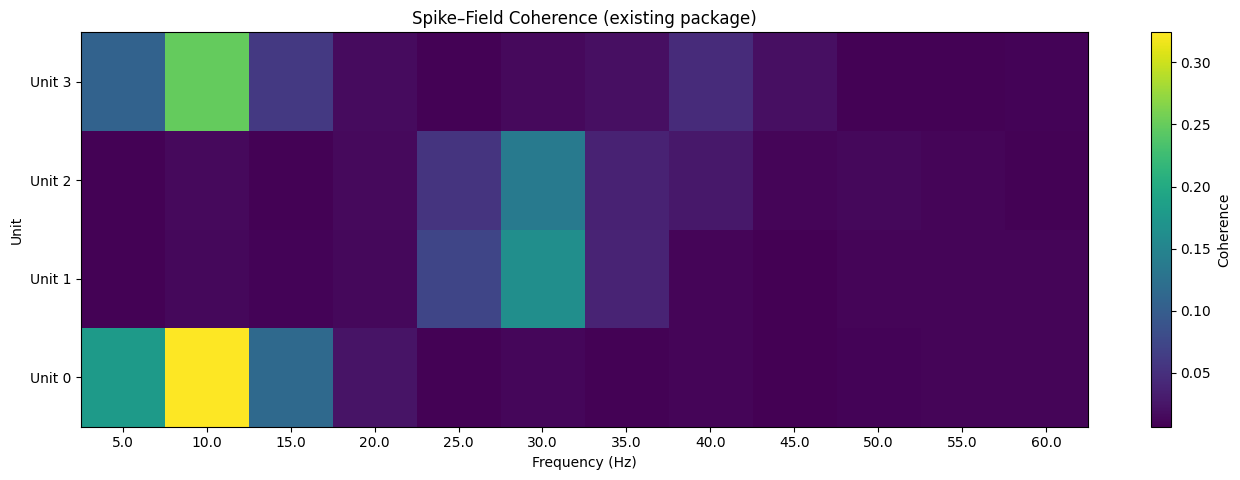

In [15]:
# === Spike–Field Coherence using an existing package (MNE) ===
import numpy as np
import matplotlib.pyplot as plt

try:
    from mne.connectivity import spectral_connectivity
    HAVE_MNE = True
except Exception:
    HAVE_MNE = False
from scipy.signal import coherence as scipy_coh  # fallback

def compute_sfc_mne(LFP_RT, spikes_RST, fs, freqs_sel, window_sec, NW):
    """
    LFP_RT       : (R, T) real float
    spikes_RST   : (R, S, T) binary/float (same fs as LFP)
    fs           : sampling rate (Hz)
    freqs_sel    : (J,) target freqs to report
    window_sec   : multitaper time window (sec) used in TFR (sets DPSS bandwidth)
    NW           : time-halfbandwidth product used in TFR (sets DPSS bandwidth)
    returns:
        sfc_SJ  : (S, J) coherence at freqs_sel for each unit
        freqs   : (F,) freq axis used (for debugging/inspection)
    """
    R, S, T = spikes_RST.shape
    assert LFP_RT.shape == (R, T), "LFP shape must be (R,T)"
    freqs_sel = np.asarray(freqs_sel, float)

    # mne: epochs x signals x time
    sfc_SJ = np.zeros((S, freqs_sel.size), float)

    if HAVE_MNE:
        fmin, fmax = float(freqs_sel.min()), float(freqs_sel.max())
        mt_bw = NW / float(window_sec)  # DPSS bandwidth (Hz)

        for s in range(S):
            data = np.stack([LFP_RT, spikes_RST[:, s, :]], axis=1)  # (R, 2, T)

            con, freqs, _, _, _ = spectral_connectivity(
                data,
                method='coh',                # magnitude-squared coherence
                mode='multitaper',
                sfreq=fs,
                fmin=fmin, fmax=fmax,
                faverage=False,
                mt_adaptive=True,            # adaptive DPSS weights (multitaper)
                mt_bandwidth=mt_bw,          # equals NW/window_sec (Hz)
                indices=([0], [1]),          # coherence between LFP(0) and spikes(1)
                verbose=False,
            )
            coh_f = con[0]                   # (F,)
            # map to your requested freqs_sel by nearest bin
            idx = np.array([np.argmin(np.abs(freqs - f)) for f in freqs_sel])
            sfc_SJ[s] = coh_f[idx]
        return sfc_SJ, freqs

    # --- Fallback: SciPy Welch coherence (no multitaper, but “existing package”) ---
    nperseg = int(round(window_sec * fs))
    noverlap = nperseg // 2
    for s in range(S):
        # average coherence over trials at the end
        coh_trials = []
        for r in range(R):
            f, c = scipy_coh(LFP_RT[r], spikes_RST[r, s],
                             fs=fs, nperseg=nperseg, noverlap=noverlap)
            coh_trials.append(c)
        coh_mean = np.mean(np.stack(coh_trials, axis=0), axis=0)  # (F,)
        idx = np.array([np.argmin(np.abs(f - fr)) for fr in freqs_sel])
        sfc_SJ[s] = coh_mean[idx]
    return sfc_SJ, f

# ==== run it on your already-generated data ====
# LFP: (R,T)   spikes: (R,S,T_fine) with T_fine == T and fs==1000 Hz
assert LFP.shape[0] == spikes.shape[0] and LFP.shape[1] == spikes.shape[2]
sfc_SJ, freqs_sfc = compute_sfc_mne(
    LFP_RT=LFP,
    spikes_RST=spikes.astype(float),   # MNE expects float
    fs=fs,
    freqs_sel=freqs_sel,               # or freqs_hz if you passed those to TFR
    window_sec=window_sec,
    NW=NW
)

# quick report
print("SFC (coherence) at requested freqs:")
for s in range(sfc_SJ.shape[0]):
    tops = np.argsort(sfc_SJ[s])[::-1][:min(5, sfc_SJ.shape[1])]
    txt = ", ".join([f"{freqs_sel[j]:.1f}Hz:{sfc_SJ[s,j]:.3f}" for j in tops])
    print(f"Unit {s}: {txt}")

# heatmap
plt.figure(figsize=(0.8*len(freqs_sel)+4, 0.6*spikes.shape[1]+2.5))
plt.imshow(sfc_SJ, aspect='auto', origin='lower', cmap='viridis')
plt.colorbar(label='Coherence')
plt.yticks(np.arange(spikes.shape[1]), [f"Unit {s}" for s in range(spikes.shape[1])])
plt.xticks(np.arange(len(freqs_sel)), [f"{f:.1f}" for f in freqs_sel])
plt.xlabel("Frequency (Hz)"); plt.ylabel("Unit")
plt.title("Spike–Field Coherence (existing package)")
plt.tight_layout(); plt.show()


In [23]:
beta_mag

array([[0.07909817, 0.00089911, 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.0489604 , 0.00091983],
       [0.        , 0.        , 0.        , 0.04086427, 0.02552676],
       [0.05707559, 0.        , 0.        , 0.        , 0.05295816]])

In [24]:
freqs_hz = np.asarray([10.0, 15.0, 20.0, 30.0, 40.0])  # J bands
